#  **SQL 데이터를 활용한 질문/응답(Q&A) 시스템 구축**

LLM(대규모 언어 모델) 시스템이 **구조화된 데이터(structured data)** 를 쿼리하도록 만드는 것은 **비구조화된 텍스트(unstructured text data)** 를 처리하는 것과는 상당히 다른 접근 방식이 필요합니다.

- **비구조화된 데이터:** 주로 벡터 데이터베이스를 사용하여 텍스트를 검색합니다.  
- **구조화된 데이터:** LLM이 SQL과 같은 언어를 사용하여 **쿼리(query)**를 작성하고 실행합니다.

다음 두 가지 구현 방식을 다룹니다:  
1. **체인(Chains)**
2. **에이전트(Agents)**

이 시스템을 통해 **데이터베이스에 대한 질문을 자연어로 입력**하고, **자연어로 답변을 받을 수 있습니다.**

- **체인:** 단일 SQL 쿼리를 실행하여 답변을 생성합니다.  
- **에이전트:** 필요에 따라 여러 번 데이터베이스를 쿼리하여 답변을 생성합니다.
---

## **아키텍처 (Architecture)**

1. **질문을 SQL 쿼리로 변환:**  
   - 모델이 사용자 입력을 SQL 쿼리로 변환합니다.  
2. **SQL 쿼리 실행:**   
   - 변환된 SQL 쿼리를 데이터베이스에서 실행합니다.  
3. **질문에 답변:**  
   - 모델이 SQL 쿼리 결과를 바탕으로 사용자 질문에 대한 답변을 생성합니다.  

In [1]:
from dotenv import load_dotenv
load_dotenv()

True

In [2]:
from langchain.chat_models import init_chat_model

model = init_chat_model("gpt-5-mini", model_provider="openai")
# model = init_chat_model("gemini-2.5-flash", model_provider="google_genai")

### **샘플 데이터**

이 예제에서는 **SQLite** 연결을 사용하여 **Chinook 데이터베이스**를 활용합니다.  
Chinook 데이터베이스는 **디지털 미디어 스토어**를 나타내는 샘플 데이터베이스입니다.

---

##  **Chinook 데이터베이스 설치**

[설치 가이드](https://database.guide/2-sample-databases-sqlite/)를 따라 `Chinook.db`를 현재 노트북과 같은 디렉터리에 생성합니다.  

또는, 아래 명령어를 사용하여 커맨드 라인에서 데이터베이스를 다운로드하고 빌드할 수 있습니다:

```bash
curl -s https://raw.githubusercontent.com/lerocha/chinook-database/master/ChinookDatabase/DataSources/Chinook_Sqlite.sql | sqlite3 Chinook.db
```

### **설명:**  
1. `curl` 명령어를 사용하여 Chinook 데이터베이스 SQL 스크립트를 다운로드합니다.  
2. `sqlite3`를 사용해 SQL 스크립트를 실행하고 `Chinook.db` 파일을 생성합니다.

---
이 데이터베이스는 **SQLAlchemy 기반의 `SQLDatabase` 클래스**를 사용하여 상호작용할 수 있습니다.

In [3]:
# SQLite3 설치 in Colab
# !sudo apt-get update
# !sudo apt-get install sqlite3

In [4]:
# Chinook db 설치 in Colab
# !curl -s https://raw.githubusercontent.com/lerocha/chinook-database/master/ChinookDatabase/DataSources/Chinook_Sqlite.sql | sqlite3 Chinook.db

In [5]:
from langchain_community.utilities import SQLDatabase

# SQLite 데이터베이스 파일 'Chinook.db'에 연결합니다.
db = SQLDatabase.from_uri("sqlite:///Chinook.db")

# 사용 중인 데이터베이스의 SQL 방언(SQL Dialect)을 출력합니다.
print(db.dialect)

# 데이터베이스에서 사용할 수 있는 테이블 이름들을 출력합니다.
print(db.get_usable_table_names())

# Artist 테이블의 상위 10개 레코드를 조회합니다
result = db.run("SELECT * FROM Artist LIMIT 10;")
result

sqlite
['Album', 'Artist', 'Customer', 'Employee', 'Genre', 'Invoice', 'InvoiceLine', 'MediaType', 'Playlist', 'PlaylistTrack', 'Track']


"[(1, 'AC/DC'), (2, 'Accept'), (3, 'Aerosmith'), (4, 'Alanis Morissette'), (5, 'Alice In Chains'), (6, 'Antônio Carlos Jobim'), (7, 'Apocalyptica'), (8, 'Audioslave'), (9, 'BackBeat'), (10, 'Billy Cobham')]"

##  **SQL 데이터베이스를 LLM과 연결하기**

주어진 질문에 대해 다음 단계를 수행하는 일련의 단계를 LangGraph를 이용하여 만들어 보겠습니다:  

- 1. 질문을 **SQL 쿼리로 변환**합니다.  
- 2. 쿼리를 **실행**합니다.  
- 3. 쿼리 **결과를 사용해 원래 질문에 답변**합니다.    

이러한 시나리오는 **에이전트(Agents)** 를 이용하여 구현해야 합니다.

---

#### **애플리케이션 상태(Application State)**

LangGraph의 **상태(State)** 는 애플리케이션에 입력되는 데이터, 단계 간에 전달되는 데이터, 그리고 출력되는 데이터를 제어합니다.  

- 일반적으로 `TypedDict`로 정의됩니다.  
- 또는, [**Pydantic BaseModel**](https://langchain-ai.github.io/langgraph/how-tos/state-model/)을 사용할 수도 있습니다.

애플리케이션 상태에서는 다음 데이터를 추적합니다:  

1. **입력된 질문 (Input Question)**  
2. **생성된 SQL 쿼리 (Generated Query)**  
3. **쿼리 결과 (Query Result)**  
4. **생성된 답변 (Generated Answer)**  

In [6]:
from typing_extensions import TypedDict, Annotated

# State 정의
class State(TypedDict):
    question: str    # 사용자로부터 입력받은 질문
    query: str         # 질문을 변환하여 생성된 SQL 쿼리
    result: str         # SQL 쿼리 실행 결과
    answer: str      # 최종적으로 생성된 LLM 답변

이제 이 상태(state)를 기반으로 작동하며 내용을 채워주는 **함수**들이 필요합니다.

---

#### **1. 질문을 SQL 쿼리로 변환하기**

첫 번째 단계는 **사용자 입력을 SQL 쿼리로 변환**하는 것입니다.  
SQL 쿼리를 신뢰성 있게 생성하기 위해 LangChain의 **구조화된 출력(structured output)** 추상화를 사용할 것입니다.

---------
이 프롬프트에는 **SQL 방언(dialect)** 과 **테이블 정보(table_info)** 와 같은 채워야 할 여러 매개변수들이 포함되어 있습니다.  

LangChain의 [`SQLDatabase`](https://python.langchain.com/api_reference/community/utilities/langchain_community.utilities.sql_database.SQLDatabase.html) 객체에는 이러한 작업을 도와주는 메서드들이 포함되어 있습니다.  

우리의 `write_query` 단계는 이 매개변수들을 채운 뒤, **모델을 프롬프트하여 SQL 쿼리를 생성**하도록 할 것입니다.

In [7]:
from langchain_core.prompts import ChatPromptTemplate

# SQL 쿼리 프롬프트 템플릿 정의
# ChatPromptTemplate을 사용해 시스템 메시지와 사용자 메시지를 구조화
query_prompt = ChatPromptTemplate.from_messages([
    ("system", """당신은 SQL 전문가입니다. 주어진 질문을 SQL 쿼리로 변환하는 작업을 수행합니다.
    다음 정보를 참고하여 SQL 쿼리를 작성하세요:
    
    방언(dialect): {dialect}
    테이블 정보: {table_info}
    최대 결과 수: {top_k}
    
    쿼리는 문법적으로 정확해야 하며, 질문에 대한 정확한 답을 제공해야 합니다."""),
    ("human", "{input}")  # 사용자의 실제 질문이 여기에 들어감
])

# TypedDict를 사용해 SQL 쿼리 출력 형식을 정의
class QueryOutput(TypedDict):
    """생성된 SQL 쿼리를 저장하는 데이터 타입입니다."""
    query: Annotated[str, "문법적으로 올바른 SQL 쿼리여야 합니다."]

# 자연어 질문을 SQL 쿼리로 변환하는 함수 작성
def write_query(state: State):
    """
    사용자 질문을 바탕으로 정보를 검색하기 위한 SQL 쿼리를 생성합니다.
    Args:
        state: 사용자 질문이 포함된 상태 객체
    Returns:
        dict: 생성된 SQL 쿼리가 포함된 딕셔너리
    """
    # 프롬프트 템플릿에 실제 값들을 주입하여 프롬프트 생성
    prompt = query_prompt.invoke({
        "dialect": db.dialect,        # 데이터베이스 방언 
        "top_k": 10,                 # 최대 반환할 결과 수
        "table_info": db.get_table_info(),  # 데이터베이스 테이블 스키마 정보
        "input": state["question"]    # 사용자가 입력한 질문
    })
    
    # LLM이 구조화된 출력(QueryOutput 형식)을 반환하도록 설정
    structured_llm = model.with_structured_output(QueryOutput)
    
    # LLM을 호출하여 SQL 쿼리 생성
    result = structured_llm.invoke(prompt)
    
    # 생성된 쿼리를 상태 객체 형식으로 반환
    return {"query": result["query"]}

# 함수 테스트 - 실제 질문으로 SQL 쿼리 생성 확인
sql_result = write_query({"question": "직원이 몇명 있나요?"})
print(sql_result) 

{'query': 'SELECT COUNT(*) AS EmployeeCount FROM Employee;'}


#### **2. 쿼리 실행 (Execute query)**

**데이터베이스 연결 권한은 가능한 한 최소화**하세요.  
또한, 쿼리를 실행하기 전에 **사람의 승인 단계(human approval step)** 를 체인에 추가하는 것을 고려하세요.

In [8]:
from langchain_community.tools.sql_database.tool import QuerySQLDatabaseTool

def execute_query(state: State):
    """
    생성된 SQL 쿼리를 실제 데이터베이스에서 실행하는 함수
    Args:
        state: SQL 쿼리가 포함된 상태 객체 (state["query"]에 SQL 쿼리 저장됨)
    Returns:
        dict: 쿼리 실행 결과가 포함된 딕셔너리
    """
    # QuerySQLDatabaseTool을 사용하여 데이터베이스 쿼리 실행 도구 생성
    # db 객체는 이미 연결된 데이터베이스 인스턴스
    execute_query_tool = QuerySQLDatabaseTool(db=db)
    
    # state["query"]에 저장된 SQL 쿼리를 실제 데이터베이스에서 실행
    # 예: "SELECT COUNT(*) FROM employees;" 실행
    result = execute_query_tool.invoke(state["query"])
    
    # 쿼리 실행 결과를 상태 객체 형식으로 반환
    # result는 문자열 형태의 쿼리 결과 (예: "[(25,)]" 또는 "25명")
    return {"result": result}
    
# sql_result는 이전 write_query 함수에서 생성된 SQL 쿼리
result = execute_query({"query": sql_result["query"]})
print(result) 

{'result': '[(8,)]'}


####  **3. 답변 생성 (Generate answer)**  

마지막 단계에서는 **데이터베이스에서 가져온 정보**를 바탕으로 질문에 대한 **답변을 생성**합니다.

In [9]:
def generate_answer(state: State):
    """
    SQL 쿼리 실행 결과를 바탕으로 사용자 질문에 대한 자연어 답변을 생성하는 함수
    Args:
        state: 사용자 질문, SQL 쿼리, 실행 결과가 모두 포함된 상태 객체
               - state["question"]: 사용자의 원래 질문
               - state["query"]: 생성된 SQL 쿼리  
               - state["result"]: SQL 실행 결과
    Returns:
        dict: 최종 자연어 답변이 포함된 딕셔너리
    """
    # LLM에게 전달할 프롬프트 구성
    # 사용자 질문, SQL 쿼리, 실행 결과를 모두 포함하여 컨텍스트 제공
    prompt = (
        "다음 사용자 질문, 해당 SQL 쿼리, 그리고 SQL 결과를 바탕으로 사용자 질문에 답하세요.\n\n"
        f'Question: {state["question"]}\n'     # 원래 사용자 질문 (예: "직원이 몇명 있나요?")
        f'SQL Query: {state["query"]}\n'       # 생성된 SQL (예: "SELECT COUNT(*) FROM employees;")
        f'SQL Result: {state["result"]}'       # 실행 결과 (예: "[(25,)]")
    )
    
    # LLM을 호출하여 자연어 답변 생성
    # 예: "현재 총 25명의 직원이 있습니다."
    response = model.invoke(prompt)
    
    # 생성된 답변을 상태 객체 형식으로 반환
    return {'answer': response.content}

#### **LangGraph를 사용한 오케스트레이션 (Orchestrating with LangGraph)**  

마지막으로, 우리의 애플리케이션을 하나의 **`graph` 객체**로 컴파일합니다.  
이 경우, **세 가지 단계를 순서(sequence)** 로 연결하기만 하면 됩니다.

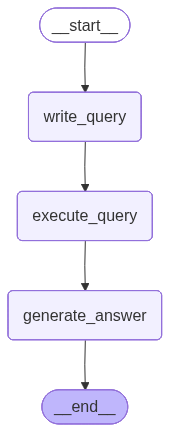

In [10]:
from langgraph.graph import START, StateGraph

# 위의 3 단계를 연결한 StateGraph 생성
workflow = StateGraph(State).add_sequence(
    [write_query, execute_query, generate_answer]
)

# 그래프의 시작점(START)과 첫 번째 단계(write_query) 연결
workflow.add_edge(START, "write_query")

# 정의된 단계와 연결 관계를 기반으로 최종 그래프 생성
app = workflow.compile()
app

각 단계를 개별적으로 **스트리밍(stream)** 하여 결과를 확인할 수 있습니다.

In [11]:
for step in app.stream(
    {"question": "직원이 몇명인가요?"},
    stream_mode="updates"
):
    print(step)

{'write_query': {'query': 'SELECT COUNT(*) AS EmployeeCount FROM Employee;'}}
{'execute_query': {'result': '[(8,)]'}}
{'generate_answer': {'answer': '직원은 총 8명입니다.'}}


####  **Human-in-the-loop (인간 개입 단계)**  

- 이 기능을 사용하면 **민감한 단계**(예: SQL 쿼리 실행) 전에 애플리케이션을 **중단(interrupt)** 하고 **사람이 검토(human review)** 할 수 있습니다.  

- 이 기능은 LangGraph의 **[persistence(영속성)](https://langchain-ai.github.io/langgraph/concepts/persistence/)** 레이어를 통해 지원됩니다.  
- 이 레이어는 애플리케이션의 실행 진행 상태(run progress)를 사용자가 선택한 저장소(storage)에 저장합니다.  

아래 예시에서는 **인메모리(in-memory)** 저장소를 지정합니다.

In [12]:
from langgraph.checkpoint.memory import MemorySaver

memory = MemorySaver()

# 위의 3 단계를 연결한 StateGraph 생성
workflow = StateGraph(State).add_sequence(
    [write_query, execute_query, generate_answer]
)

# 그래프의 시작점(START)과 첫 번째 단계(write_query) 연결
workflow.add_edge(START, "write_query")

# 정의된 단계와 연결 관계를 기반으로 최종 그래프 생성
app = workflow.compile(checkpointer=memory, interrupt_before=['execute_query'])
app;

In [13]:
# 영속성을 사용할 때는 실행을 이어갈 수 있도록 고유 식별 스레드 ID를 지정
config = {"configurable": {"thread_id": "1"}}

for step in app.stream(
    {"question": "직원이 몇명인가요?"},
    stream_mode="updates",
    config=config
):
    print(step)

{'write_query': {'query': 'SELECT COUNT(*) AS employee_count FROM Employee;'}}
{'__interrupt__': ()}


----------
동일한 실행(run)을 반복하되, 간단한 **예/아니오(yes/no) 승인 단계**를 추가해보겠습니다.

In [14]:
# 영속성을 사용할 때는 실행을 이어갈 수 있도록 고유 식별 스레드 ID를 지정
config = {"configurable": {"thread_id": "1"}}

# 그래프 실행 - invoke로 전체 워크플로우 실행하여 최종 결과 받기
result = app.invoke(
    {"question": "직원이 몇 명 있나요?"},    # 사용자 입력 질문
    config         # 스레드 ID 및 설정 정보
)
print("첫 번째 실행 결과:")
print(result)  # 전체 실행 결과 출력 (중단 지점까지의 결과)

# execute_query 단계 전에 사용자 승인 여부 확인
try:
    user_approval = input("쿼리를 실행하시겠습니까? (yes/no): ")  # 사용자 승인 입력
except Exception:
    user_approval = "no"  # 예외 발생 시 기본값으로 'no' 설정
    
# 승인 확인
if user_approval.lower() == "yes":
    # 중단된 지점부터 계속 실행하여 최종 결과 받기
    final_result = app.invoke(
        None,      # 입력 없음 (이전 상태에서 계속)
        config     # 동일한 스레드 ID로 이어서 실행
    )
    print("최종 실행 결과:")
    print(final_result)  # 전체 워크플로우 완료 후 최종 결과
else:
    # 사용자가 'no'를 입력한 경우, 실행 중단
    print("사용자가 작업을 취소했습니다.")

첫 번째 실행 결과:
{'question': '직원이 몇 명 있나요?', 'query': 'SELECT COUNT(*) AS EmployeeCount FROM Employee;'}


쿼리를 실행하시겠습니까? (yes/no):  yes


최종 실행 결과:
{'question': '직원이 몇 명 있나요?', 'query': 'SELECT COUNT(*) AS EmployeeCount FROM Employee;', 'result': '[(8,)]', 'answer': '총 8명입니다. (Employee 테이블의 COUNT(*) 결과 = 8)'}


##  **에이전트(Agents) 사용**

**에이전트(Agents)** 는 **LLM의 추론(reasoning) 능력**을 활용하여 실행 중에 결정을 내립니다.  
에이전트를 사용하면 **쿼리 생성 및 실행 과정의 추가적인 판단(discretion)** 을 LLM에 맡길 수 있습니다.  

**에이전트**에는 몇 가지 장점이 있습니다:

- 사용자 질문에 답하기 위해 **필요한 만큼 데이터베이스를 여러 번 쿼리**할 수 있습니다.  
- 생성된 쿼리를 실행하다 오류가 발생하면, **오류(traceback)를 포착**하여 올바르게 **재생성(regenerate)** 할 수 있습니다.  
- 데이터베이스의 **스키마(schema)** 와 **내용(content)** 모두를 기반으로 질문에 답할 수 있습니다 (예: 특정 테이블 설명).  

**LangGraph의 [사전 구축된 ReAct 에이전트 생성자(pre-built ReAct agent constructor)](https://langchain-ai.github.io/langgraph/how-tos/#langgraph.prebuilt.chat_agent_executor.create_react_agent)** 를 사용하면 **한 줄의 코드**로 이를 수행할 수 있습니다.

---
LangChain의 [**SQLDatabaseToolkit**](https://python.langchain.com/api_reference/community/agent_toolkits/langchain_community.agent_toolkits.sql.toolkit.SQLDatabaseToolkit.html)을 사용하여 도구(tool) 세트를 제공합니다. 

`SQLDatabaseToolkit`에는 다음과 같은 도구들이 포함됩니다:

- **쿼리 생성 및 실행(Create and execute queries)**  
- **쿼리 구문 검증(Check query syntax)**  
- **테이블 설명 가져오기(Retrieve table descriptions)**  
- **기타 여러 기능(... and more)**  

In [15]:
from langchain_community.agent_toolkits import SQLDatabaseToolkit

# SQLDatabaseToolkit은 LLM과 데이터베이스(SQL)를 연결하기 위한 도구 세트
toolkit = SQLDatabaseToolkit(db=db, llm=model)

# SQLDatabaseToolkit에서 사용할 수 있는 모든 도구를 가져옵니다.
tools = toolkit.get_tools()

tool_names = [tool.name for tool in tools]
tool_names

['sql_db_query', 'sql_db_schema', 'sql_db_list_tables', 'sql_db_query_checker']

In [16]:
prompt_template = (
    """
    당신은 SQL 전문가입니다. 주어진 질문에 답하기 위해 반드시 다음 순서를 따라 작업을 완료하세요:
    
    **필수 작업 순서:**
    1. 질문을 분석하여 적절한 SQL 쿼리를 작성하세요
    2. 작성한 SQL 쿼리를 반드시 sql_db_query 도구를 사용해서 실행하세요
    3. 실행 결과를 바탕으로 사용자 질문에 대한 명확한 답변을 제공하세요
    
    **데이터베이스 정보:**
    - 방언(dialect): {dialect}
    - 테이블 정보: {table_info}
    - 최대 결과 수: {top_k}
    
    **중요 지침:**
    - 쿼리는 문법적으로 정확해야 하며, 질문에 대한 정확한 답을 제공해야 합니다
    - SQL 쿼리를 제안만 하지 말고, 반드시 실제로 실행하여 결과를 확인하세요
    - 실행 결과 없이는 답변을 완료한 것이 아닙니다
    - 도구 실행 후 나온 결과를 사용자가 이해하기 쉽게 해석해서 답변하세요
    
    **사용 가능한 도구:**
    - sql_db_query: SQL 쿼리를 실행하여 실제 데이터를 조회하는 도구
    """
)

프롬프트에서 강조된 **매개변수(parameters)** 를 채워보겠습니다.

In [17]:
system_message = prompt_template.format(dialect="SQLite", table_info=db.get_table_info(), top_k=5)
system_message

'\n    당신은 SQL 전문가입니다. 주어진 질문에 답하기 위해 반드시 다음 순서를 따라 작업을 완료하세요:\n\n    **필수 작업 순서:**\n    1. 질문을 분석하여 적절한 SQL 쿼리를 작성하세요\n    2. 작성한 SQL 쿼리를 반드시 sql_db_query 도구를 사용해서 실행하세요\n    3. 실행 결과를 바탕으로 사용자 질문에 대한 명확한 답변을 제공하세요\n\n    **데이터베이스 정보:**\n    - 방언(dialect): SQLite\n    - 테이블 정보: \nCREATE TABLE "Album" (\n\t"AlbumId" INTEGER NOT NULL, \n\t"Title" NVARCHAR(160) NOT NULL, \n\t"ArtistId" INTEGER NOT NULL, \n\tPRIMARY KEY ("AlbumId"), \n\tFOREIGN KEY("ArtistId") REFERENCES "Artist" ("ArtistId")\n)\n\n/*\n3 rows from Album table:\nAlbumId\tTitle\tArtistId\n1\tFor Those About To Rock We Salute You\t1\n2\tBalls to the Wall\t2\n3\tRestless and Wild\t2\n*/\n\n\nCREATE TABLE "Artist" (\n\t"ArtistId" INTEGER NOT NULL, \n\t"Name" NVARCHAR(120), \n\tPRIMARY KEY ("ArtistId")\n)\n\n/*\n3 rows from Artist table:\nArtistId\tName\n1\tAC/DC\n2\tAccept\n3\tAerosmith\n*/\n\n\nCREATE TABLE "Customer" (\n\t"CustomerId" INTEGER NOT NULL, \n\t"FirstName" NVARCHAR(40) NOT NULL, \n\t"LastName" NVARCHAR(20) NOT NU

#### **에이전트 초기화 (Initializing Agent)**  

사전 구축된 **LangGraph** 에이전트를 사용하여 **에이전트(agent)** 를 생성합니다.

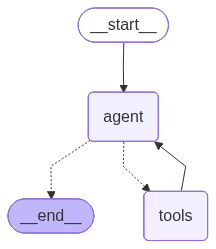

In [18]:
from langchain_core.messages import HumanMessage
from langgraph.prebuilt import create_react_agent

# ReAct(Reasoning + Acting) 패턴을 사용하여 에이전트 생성
agent_executor = create_react_agent(
    model,         # LLM 객체
    tools,        # SQL 쿼리 실행, 스키마 확인 등의 작업을 수행할 수 있는 도구 목록
    prompt=system_message
)

agent_executor

In [19]:
question = "직원이 몇명인가요?"

# stream을 invoke로 변경 - 전체 실행 후 최종 결과만 받기
result = agent_executor.invoke(
    {'messages': [{'role': 'user', 'content': question}]}
)

# 최종 결과에서 마지막 메시지 출력
result['messages'][-1].pretty_print()

================================== Ai Message ==================================

요청하신 대로 SQL을 실행했습니다.

실행한 쿼리:
SELECT COUNT(*) AS employee_count FROM Employee;

결과:
employee_count = 8

따라서 직원 수는 총 8명입니다.


#### Agent 의 사고 과정을 실시간으로 보려면 `stream` 을 사용하여 중간 단계를 출력합니다.

In [20]:
question = "직원이 몇명인가요?"

for step in agent_executor.stream(
    {'messages': [{'role': 'user', 'content': question}]},
    stream_mode='values'   #각 단계의 최종 결과 값만 제공
):
    step['messages'][-1].pretty_print()

================================ Human Message =================================

직원이 몇명인가요?
================================== Ai Message ==================================
Tool Calls:
  sql_db_query_checker (call_PrQ0Wwq8uO036YlSu7lmdJOL)
 Call ID: call_PrQ0Wwq8uO036YlSu7lmdJOL
  Args:
    query: SELECT COUNT(*) AS employee_count FROM Employee;
================================= Tool Message =================================
Name: sql_db_query_checker

SELECT COUNT(*) AS employee_count FROM Employee;
================================== Ai Message ==================================
Tool Calls:
  sql_db_query (call_90EvZDFZMMBTYhQXKLwRMhUh)
 Call ID: call_90EvZDFZMMBTYhQXKLwRMhUh
  Args:
    query: SELECT COUNT(*) AS employee_count FROM Employee;
================================= Tool Message =================================
Name: sql_db_query

[(8,)]
================================== Ai Message ==================================

직원 수를 확인하기 위해 SQL 쿼리를 실행했습니다.

실행한 쿼리:
SELECT COUNT(*) 

In [21]:
question = "어느 나라의 고객이 가장 많은 금액을 지출했나요?"

for step in agent_executor.stream(
    {'messages': [{'role': 'user', 'content': question}]},
    stream_mode='values'   #각 단계의 최종 결과 값만 제공
):
    step['messages'][-1].pretty_print()

================================ Human Message =================================

어느 나라의 고객이 가장 많은 금액을 지출했나요?
================================== Ai Message ==================================
Tool Calls:
  sql_db_query_checker (call_m5YPk7fYixkWmaLfylFAiygQ)
 Call ID: call_m5YPk7fYixkWmaLfylFAiygQ
  Args:
    query: SELECT BillingCountry, SUM(Total) AS TotalSpent
FROM Invoice
GROUP BY BillingCountry
ORDER BY TotalSpent DESC
LIMIT 1;
================================= Tool Message =================================
Name: sql_db_query_checker

SELECT BillingCountry, SUM(Total) AS TotalSpent
FROM Invoice
GROUP BY BillingCountry
ORDER BY TotalSpent DESC
LIMIT 1;
================================== Ai Message ==================================
Tool Calls:
  sql_db_query (call_vhTzR8z5XKG8tWr8hrxMnmXr)
 Call ID: call_vhTzR8z5XKG8tWr8hrxMnmXr
  Args:
    query: SELECT BillingCountry, SUM(Total) AS TotalSpent
FROM Invoice
GROUP BY BillingCountry
ORDER BY TotalSpent DESC
LIMIT 5;
==================

In [22]:
# SQL 쿼리로 검증
validation_query = """
SELECT BillingCountry, SUM(Total) AS TotalSpent
FROM Invoice
GROUP BY BillingCountry
ORDER BY TotalSpent DESC
LIMIT 1;
"""

validation_result = db.run(validation_query)
print("검증용 SQL 쿼리 결과:", validation_result)

검증용 SQL 쿼리 결과: [('USA', 523.06)]


에이전트는 필요한 정보를 얻을 때까지 **여러 번의 쿼리**를 실행한다는 점에 주목하세요:  

1. 사용 가능한 테이블 목록을 나열합니다.  
2. 세 개의 테이블에 대한 스키마를 검색합니다.  
3. 여러 테이블을 **JOIN 연산**을 통해 쿼리합니다.  

에이전트는 마지막 쿼리의 결과를 사용해 **원래 질문에 대한 답변을 생성**할 수 있습니다.

에이전트는 이와 유사하게 **정성적 질문(qualitative questions)** 도 처리할 수 있습니다.

In [ ]:
question = "`playlisttrack` 테이블을 설명하세요. 한국어로 설명하세요.**"

for step in agent_executor.stream(
    {"messages": [{"role": "user", "content": question}]},
    stream_mode="values",
):
    step["messages"][-1].pretty_print()

================================ Human Message =================================

`playlisttrack` 테이블을 설명하세요. 한국어로 설명하세요.**
================================== Ai Message ==================================
Tool Calls:
  sql_db_query_checker (call_loYH0mqwfhz5mbyew62nBOm4)
 Call ID: call_loYH0mqwfhz5mbyew62nBOm4
  Args:
    query: PRAGMA table_info("PlaylistTrack");
================================= Tool Message =================================
Name: sql_db_query_checker

PRAGMA table_info("PlaylistTrack");
================================== Ai Message ==================================
Tool Calls:
  sql_db_query (call_zwC79U8HHylTz0Eb39SYRJru)
 Call ID: call_zwC79U8HHylTz0Eb39SYRJru
  Args:
    query: PRAGMA table_info("PlaylistTrack");
================================= Tool Message =================================
Name: sql_db_query

[(0, 'PlaylistId', 'INTEGER', 1, None, 1), (1, 'TrackId', 'INTEGER', 1, None, 2)]
================================== Ai Message ========================